# BBC News Summary

Link: https://www.kaggle.com/datasets/pariza/bbc-news-summary

Dataset description:

Context

Text summarization is a way to condense the large amount of information into a concise form by the process of selection of important information and discarding unimportant and redundant information. With the amount of textual information present in the world wide web the area of text summarization is becoming very important. The extractive summarization is the one where the exact sentences present in the document are used as summaries. The extractive summarization is simpler and is the general practice among the automatic text summarization researchers at the present time. Extractive summarization process involves giving scores to sentences using some method and then using the sentences that achieve highest scores as summaries. As the exact sentence present in the document is used the semantic factor can be ignored which results in generation of less calculation intensive summarization procedure. This kind of summary is generally completely unsupervised and language independent too. Although this kind of summary does its job in conveying the essential information it may not be necessarily smooth or fluent. Sometimes there can be almost no connection between adjacent sentences in the summary resulting in the text lacking in readability.
Content

This dataset for extractive text summarization has four hundred and seventeen political news articles of BBC from 2004 to 2005 in the News Articles folder. For each articles, five summaries are provided in the Summaries folder. The first clause of the text of articles is the respective title.
Acknowledgements

This dataset was created using a dataset used for data categorization that onsists of 2225 documents from the BBC news website corresponding to stories in five topical areas from 2004-2005 used in the paper of D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006; whose all rights, including copyright, in the content of the original articles are owned by the BBC. More at http://mlg.ucd.ie/datasets/bbc.html


Usefull:

https://huggingface.co/learn/nlp-course/chapter7/5?fw=tf

In [1]:
!pip install transformers -qU
!pip install datasets -qU
!pip install pip install pytorch-lightning -qU
!pip install rouge_score -qU
!pip install nltk -qU

In [2]:
!pip install nltk

In [4]:
import re
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from collections import Counter
import torch

import torch.nn.functional as F

import datasets
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler,random_split, Dataset
from torch.nn.functional import pad
from transformers import AutoTokenizer, BertForTokenClassification, AdamW, BertConfig
from transformers import AutoTokenizer, AutoModelForCausalLM

from tqdm.auto import tqdm
#import evaluate

import nltk
nltk.download("punkt")

import warnings
warnings.filterwarnings(action="ignore")

pd.set_option('display.max_colwidth', 3000)
pd.set_option('display.max_columns', None)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


device(type='cpu')

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data

In [6]:
def read_file_from_path(path):
    with open(path, "r", encoding='utf-8') as f:
        content = f.read()
    return content

In [7]:
import os
import pandas as pd

folder_path = "/content/drive/MyDrive/Colab Notebooks/data/"
categories = os.listdir(folder_path + "Summaries/")

frames = []

for category in categories:
    files = os.listdir(os.path.join(folder_path, "Summaries/", category))
    tmp_df = pd.DataFrame(files, columns=["FileName"])
    tmp_df["Category"] = category
    frames.append(tmp_df)

df = pd.concat(frames).head(100)

df["SummaryFullPath"] = df.apply(lambda row: os.path.join(folder_path, "Summaries", row["Category"], row["FileName"]), axis=1)
df["ArticleFullPath"] = df.apply(lambda row: os.path.join(folder_path, "News Articles", row["Category"], row["FileName"]), axis=1)
df["Summary"] = df["SummaryFullPath"].apply(lambda path: read_file_from_path(path))
df["SummaryLen"] = df["Summary"].apply(lambda summary: len(summary.split()))

df["Article"] = df["ArticleFullPath"].apply(lambda path: read_file_from_path(path))
df["ArticleLen"] = df["Article"].apply(lambda summary: len(summary.split()))


df#.drop("FileName")

,FileName,Category,SummaryFullPath,ArticleFullPath,Summary,SummaryLen,Article,ArticleLen
0,014.txt,business,/content/drive/MyDrive/Colab Notebooks/data/Summaries/business/014.txt,/content/drive/MyDrive/Colab Notebooks/data/News Articles/business/014.txt,"""Journalists are the lifeblood of any newspaper, and maintaining the quality of The Daily Telegraph and The Sunday Telegraph for our readers is vital,"" he said.The two Telegraph titles currently employ 521 journalists.Telegraph executive Murdoch MacLennan said the two newspapers would add eight colour pages in the coming months.The Daily and Sunday Telegraph newspapers are axing 90 journalist jobs - 17% of their editorial staff.The Telegraph Group says the cuts are needed to fund an £150m investment in new printing facilities.The National Union of Journalists said it stood strongly behind the journalists and did not rule out a strike.The Telegraph has announced no plans to go tabloid although both The Independent and The Times have seen circulation rise since shrinking in size.Many newspapers are investing in new printing machinery that enables them to print more colour pages, or in some cases, have colour on every page.NUJ official Barry Fitzpatrick said the company had ignored the 90-day consultation period required for companies planning more than 10 redundancies.",166,"Telegraph newspapers axe 90 jobs\n\nThe Daily and Sunday Telegraph newspapers are axing 90 journalist jobs - 17% of their editorial staff.\n\nThe Telegraph Group says the cuts are needed to fund an £150m investment in new printing facilities. Journalists at the firm met on Friday afternoon to discuss how to react to the surprise announcement. The cuts come against a background of fierce competition for readers and sluggish advertising revenues amid competition from online advertising. The National Union of Journalists has called on the management to recall the notice of redundancy by midday on Monday or face a strike ballot.\n\nPearson's Financial Times said last week it was offering voluntary redundancy to about 30 reporters.\n\nThe National Union of Journalists said it stood strongly behind the journalists and did not rule out a strike. ""Managers have torn up agreed procedures and kicked staff in the teeth by sacking people to pay for printing facilities,"" said Jeremy Dear, NUJ General Secretary. NUJ official Barry Fitzpatrick said the company had ignored the 90-day consultation period required for companies planning more than 10 redundancies. ""They have shown a complete disregard for the consultative rights of our members,"" said Mr Fitzpatrick, who added that the company now planned to observe the consultation procedures. The two Telegraph titles currently employ 521 journalists.\n\nSome broadsheet newspapers - especially those which have not moved to a tabloid format - have suffered circulation declines, which are hitting revenues. The Telegraph has announced no plans to go tabloid although both The Independent and The Times have seen circulation rise since shrinking in size.\n\nThe Guardian is hedging its bets, planning a larger tabloid format like those popular in continental Europe. The Telegraph Group was bought by the Barclay twins - Frederick and David - last year, having previously been owned by Lord Conrad Black's Hollinger International. The brothers are currently mulling the sale of another of their businesses, retailer Littlewoods.\n\nTelegraph executive Murdoch MacLennan said the two newspapers would add eight colour pages in the coming months.\n\n""Journalists are the lifeblood of any newspaper, and maintaining the quality of The Daily Telegraph and The Sunday Telegraph for our readers is vital,"" he said. ""However, action to improve our production capability and secure our titles against the competition is also vital."" Many newspapers are investing in new printing machinery that enables them to print more colour pages, or in some cases, have colour on every page. They are hoping tha

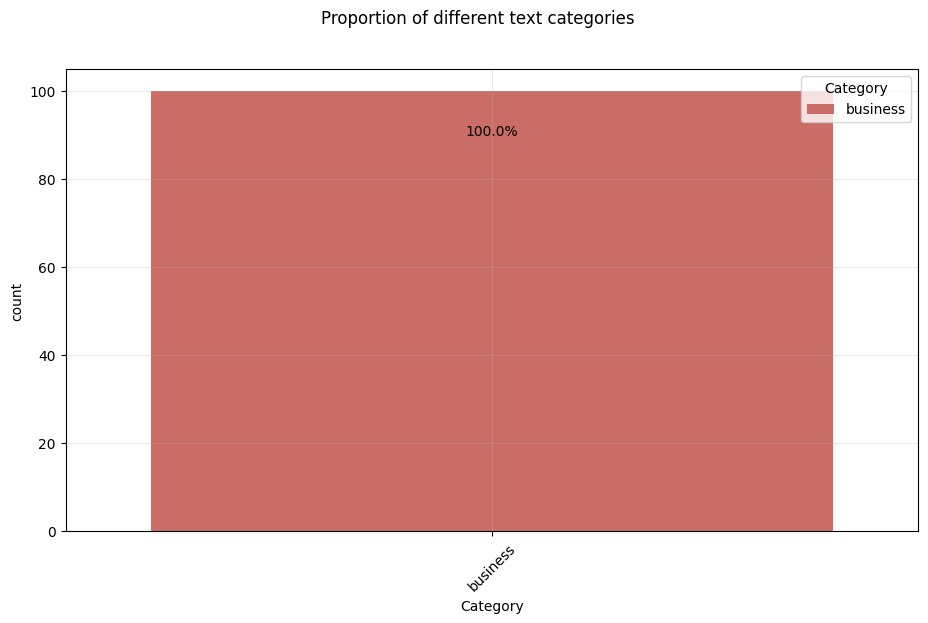

In [8]:
fig, ax = plt.subplots(figsize=(11,6))
fig.suptitle("Proportion of different text categories")

sns.countplot(data=df, x="Category", hue="Category", palette="hls", ax=ax)
ax.grid(alpha=0.25)
ax.tick_params(axis='x', rotation=45)

total = len(df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height() * 0.9
    ax.annotate(percentage, (x, y), ha='center')

fig.show()

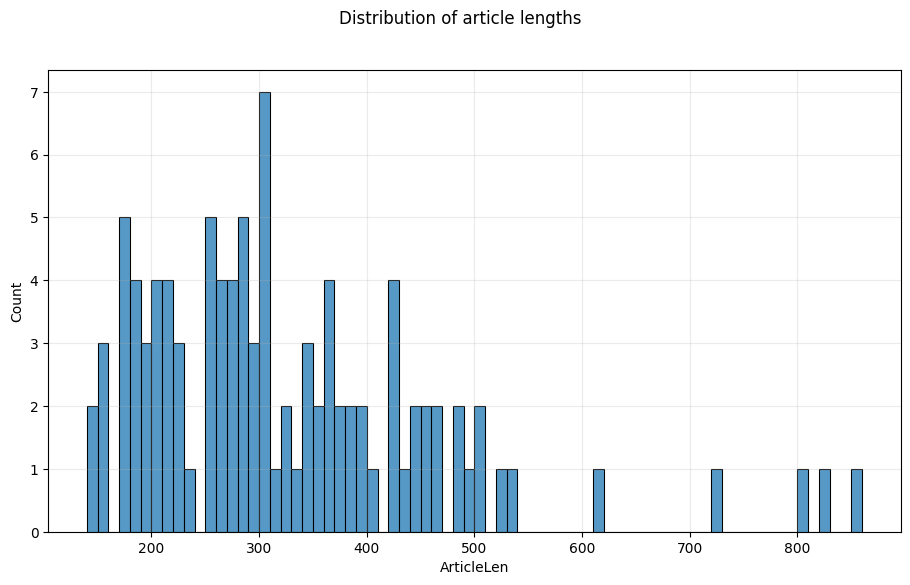

In [9]:
fig, ax = plt.subplots(figsize=(11,6))
fig.suptitle("Distribution of article lengths")

sns.histplot(data=df, x="ArticleLen", palette="hls", ax=ax, binwidth=10)
ax.grid(alpha=0.25)
#ax.tick_params(axis='x', rotation=45)

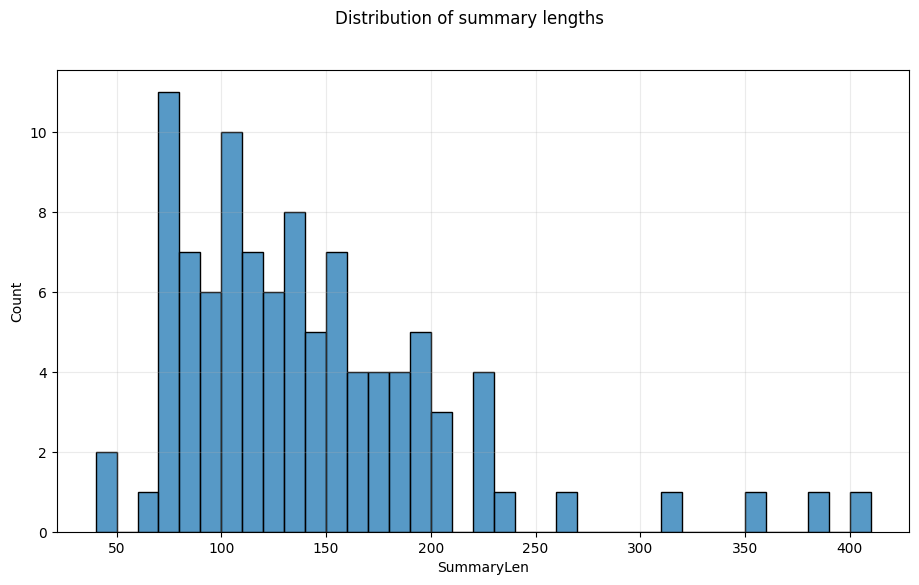

In [10]:
fig, ax = plt.subplots(figsize=(11,6))
fig.suptitle("Distribution of summary lengths")

sns.histplot(data=df, x="SummaryLen", palette="hls", ax=ax, binwidth=10)
ax.grid(alpha=0.25)
#ax.tick_params(axis='x', rotation=45)

# Model & tokenizer

In [12]:
#model_name_or_path = "facebook/bart-large-cnn"

tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")
model = AutoModelForCausalLM.from_pretrained("facebook/bart-base").to(device)

#tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
#model = AutoModelForCausalLM.from_pretrained(model_name_or_path).to(device)

print(f"\nTokenizer max len: {tokenizer.model_max_length}")
print(tokenizer.special_tokens_map)
print("bos token: ", tokenizer.bos_token, tokenizer.bos_token_id)
print("eos token: ", tokenizer.eos_token, tokenizer.eos_token_id)
print("unk token: ", tokenizer.unk_token, tokenizer.unk_token_id)

Some weights of BartForCausalLM were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['lm_head.weight', 'decoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Tokenizer max len: 1024
{'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}
bos token:  <s> 0
eos token:  </s> 2
unk token:  <unk> 3


## Dataset & Dataloaders

In [13]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer):
        super().__init__()
        self.summaries = df["Summary"].values
        self.articles = df["Article"].values
        self.len = len(df)
        self.max_summary_len = 512
        self.max_article_len = 1024

    def __getitem__(self, idx):

        summary = self.summaries[idx]
        article = self.articles[idx]

        encoded_article = tokenizer(article,
                                 add_special_tokens = True,
                                 return_attention_mask = True,
                                 return_token_type_ids=True,
                                 truncation=True,
                                 max_length = self.max_article_len,
                                 return_tensors = 'pt',
                   )
        encoded_summary = tokenizer(summary,
                                 add_special_tokens = False,
                                 return_attention_mask = False,
                                 return_token_type_ids=False,
                                 truncation=True,
                                 max_length = self.max_summary_len,
                                 return_tensors = 'pt',
                   )

        return encoded_article['input_ids'][0], encoded_article['attention_mask'][0], encoded_summary["input_ids"][0]

    def __len__(self):
        return self.len

In [14]:
from torch.nn import ConstantPad1d

def padding_function(x, max_len):
    return ConstantPad1d((0, max_len - len(x)), 0)(x)

def shift_right(labels, n=1):
    padding = -100 * torch.ones(n)
    return torch.concat([padding, labels[:-n]])

def collate_fn(batch):
    max_len = max([len(sample[0]) for sample in batch])
    ids = torch.stack([padding_function(sample[0], max_len) for sample in batch])
    attention_masks = torch.stack([shift_right(padding_function(sample[1], max_len)) for sample in batch])
    labels = torch.stack([padding_function(sample[2], max_len) for sample in batch])
    return ids.to(device), attention_masks.to(device), labels.to(device)

In [15]:
dataset = CustomDataset(df, tokenizer)
train_size = int(0.8 * len(dataset))
validation_size = len(dataset)  - train_size
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(validation_size))

   80 training samples
   20 validation samples


In [16]:

batch_size = 4

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size,
            collate_fn=collate_fn
        )

validation_dataloader = DataLoader(
            validation_dataset,
            sampler = SequentialSampler(validation_dataset),
            batch_size = batch_size,
            collate_fn=collate_fn
        )

In [17]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Training

In [ ]:
start_time = time.time()

epochs = 2
avg_train_accuracy = []
avg_train_loss = []
avg_val_loss = []
avg_val_accuracy = []

for epoch_i in range(0, epochs):

    running_train_loss = 0
    running_train_accuracy = 0
    running_val_loss = 0
    running_val_accuracy = 0

    model.train()

    loop = tqdm(train_dataloader)

    for batch in loop:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        optimizer.zero_grad()

        output = model(b_input_ids,
                       attention_mask=b_input_mask,
                       labels=b_labels)
        print(output.loss)
        loss = output.loss
        running_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        loop.set_description(f"Training. Epoch [{epoch_i}/{epochs}]")

    avg_train_accuracy.append(running_train_accuracy / train_size)
    avg_train_loss.append(running_train_loss / train_size)

    model.eval()
    with torch.no_grad():
        loop = tqdm(validation_dataloader)
        for batch in loop:

            b_input_ids = batch[0].to(device)
            b_input_token_type = batch[1].to(device)
            b_input_mask = batch[2].to(device)

            output = model(b_input_ids,
                       token_type_ids=b_input_token_type,
                       attention_mask=b_input_mask,
                       labels=b_input_ids)


            loss = output.loss
            running_val_loss += loss.item()

            loop.set_description(f"Validation. Epoch [{epoch_i}/{epochs}]\tloss {loss.item()}")

    avg_val_accuracy.append(running_val_accuracy / len(validation_dataset))
    avg_val_loss.append(running_val_loss / len(validation_dataloader))

  0%|          | 0/20 [00:00<?, ?it/s]

tensor(9.2630, grad_fn=<NllLossBackward0>)
tensor(8.2802, grad_fn=<NllLossBackward0>)
tensor(6.8949, grad_fn=<NllLossBackward0>)
tensor(5.7064, grad_fn=<NllLossBackward0>)
tensor(4.0300, grad_fn=<NllLossBackward0>)
tensor(3.0432, grad_fn=<NllLossBackward0>)


## Eval

In [ ]:
rouge_score = evaluate.load("rouge")
scores = rouge_score.compute(
    predictions=[generated_summary], references=[reference_summary]
)
scores

In [ ]:
# Baseline

from nltk.tokenize import sent_tokenize


def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])


#print(three_sentence_summary(books_dataset["train"][1]["review_body"]))

def evaluate_baseline(dataset, metric):
    summaries = [three_sentence_summary(text) for text in dataset["review_body"]]
    return metric.compute(predictions=summaries, references=dataset["review_title"])

In [ ]:
# https://huggingface.co/blog/how-to-generate

def predict(record):

    model_inputs = tokenizer(record["FullDescription"], record["Example"],
                             add_special_tokens = True,
                             return_attention_mask = True,
                             return_token_type_ids=True,
                             return_tensors = 'pt'
                            )

    # set top_k to 50
    sample_output = model.generate(
        **model_inputs,
        max_new_tokens=40,
        do_sample=True,
        top_k=50
    )

    print("Input:\n" + 100 * '-')
    print(record["FullDescription"], record["Example"])
    print("Output:\n" + 100 * '-')
    print(tokenizer.decode(sample_output[0], skip_special_tokens=True))
